CODE BLOCK: 1

In [1]:
from google.colab import files
files.upload()

Saving utils.py to utils.py


{'utils.py': b'\n\'\'\'\nUtils for trasforming the train and test dataset\nUtils to plot graphs\n    - plot train train samples\n    - plot losses and accuracies\n\'\'\'\nfrom torchvision import datasets, transforms\nimport matplotlib.pyplot as plt\n\n# Train data transformations\ntrain_transforms = transforms.Compose([\n    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),\n    transforms.Resize((28, 28)),\n    transforms.RandomRotation((-15., 15.), fill=0),\n    transforms.ToTensor(),\n    transforms.Normalize((0.1307,), (0.3081,)),\n    ])\n\n# Test data transformations\ntest_transforms = transforms.Compose([\n    transforms.ToTensor(),\n    transforms.Normalize((0.1407,), (0.4081,))\n    ])\n\n\n\ndef plot_train_samples(train_loader):\n\n    batch_data, batch_label = next(iter(train_loader))\n\n    fig = plt.figure()\n\n    for i in range(12):\n        plt.subplot(3,4,i+1)\n        plt.tight_layout()\n        plt.imshow(batch_data[i].squeeze(0), cmap=\'gray\')\n        

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
#from model import Net
from utils import *

# New section

CODE BLOCK: 2

In [3]:
# CUDA?
#cuda = if torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("CUDA Available?", device)

CUDA Available? cuda


CODE BLOCK: 3

CODE BLOCK: 4

In [4]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 106861128.52it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 84888362.88it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28003188.25it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12820005.90it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



CODE BLOCK: 5

In [5]:
batch_size = 512 # 512 but why ?

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(train_data, **kwargs)
train_loader = torch.utils.data.DataLoader(test_data, **kwargs)

CODE BLOCK: 6

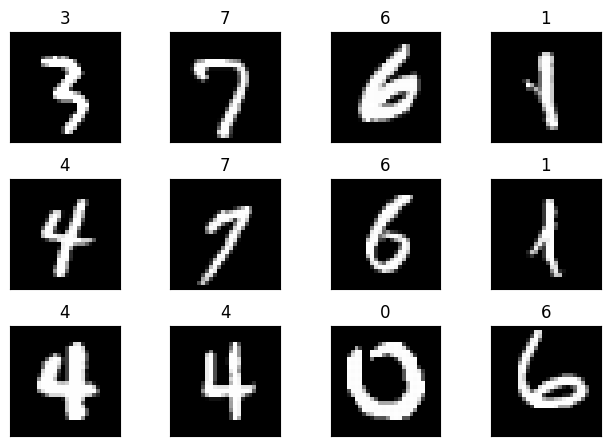

In [6]:
plot_train_samples(train_loader)

CODE BLOCK: 7

CODE BLOCK: 8

In [7]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 8

In [8]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 9

In [11]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
                                nn.Conv2d(1, 8, kernel_size=3),
                                nn.BatchNorm2d(8),
                                #nn.Dropout(0.1),
                                nn.ReLU()

                              )
        self.conv2 = nn.Sequential(
                                nn.Conv2d(8, 16, kernel_size=3),
                                nn.BatchNorm2d(16),
                                #nn.Dropout(0.1),
                                nn.ReLU(),

                                nn.MaxPool2d(kernel_size=2, stride=2)
                              )
        self.conv3 = nn.Sequential(
                                nn.Conv2d(16, 32, kernel_size=3),
                                nn.BatchNorm2d(32),
                                nn.Conv2d(32, 16, kernel_size=1),
                                nn.ReLU(),
                                #nn.Dropout(0.1),
                                nn.ReLU()
                                #nn.MaxPool2d(kernel_size=2, stride=2)
                              )
        self.conv4 = nn.Sequential(
                                nn.Conv2d(16, 10, kernel_size=3,),
                                nn.BatchNorm2d(10),
                                #nn.Dropout(0.1),
                                nn.ReLU()
                                #nn.MaxPool2d(kernel_size=2, stride=2),
                                #nn.Conv2d(32, 64, kernel_size=3)

                              )
        self.gap =  nn.AdaptiveAvgPool2d(1) # nn.AvgPool2d(8)
        #self.fc = nn.Linear(40, 10)
        #self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        #x = F.relu(self.fc1(x))
        #x = self.fc(x)
        #x = self.fc2(x)
        return F.log_softmax(x, dim=1)

'''
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.conv3 = nn.Conv2d(16, 20, kernel_size=3)
        self.conv4 = nn.Conv2d(20, 32, kernel_size=3)
        self.gap = nn.AdaptiveAvgPool2d(1)
        #self.fc1 = nn.Linear(32, 16)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x),2)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(self.conv3(x),2)
        x = F.relu(F.max_pool2d(self.conv4(x), 2))
        x = self.gap(x)
        x = x.view(-1, 32)
        #x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

'''

'\n        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)\n        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)\n        self.conv3 = nn.Conv2d(16, 20, kernel_size=3)\n        self.conv4 = nn.Conv2d(20, 32, kernel_size=3)\n        self.gap = nn.AdaptiveAvgPool2d(1)\n        #self.fc1 = nn.Linear(32, 16)\n        self.fc2 = nn.Linear(32, 10)\n\n    def forward(self, x):\n        x = F.relu(self.conv1(x),2)\n        x = F.relu(F.max_pool2d(self.conv2(x), 2))\n        x = F.relu(self.conv3(x),2)\n        x = F.relu(F.max_pool2d(self.conv4(x), 2))\n        x = self.gap(x)\n        x = x.view(-1, 32)\n        #x = F.relu(self.fc1(x))\n        x = self.fc2(x)\n        return F.log_softmax(x, dim=1)\n\n'

In [12]:
model = Net().to(device)
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
            Conv2d-4           [-1, 16, 24, 24]           1,168
       BatchNorm2d-5           [-1, 16, 24, 24]              32
              ReLU-6           [-1, 16, 24, 24]               0
         MaxPool2d-7           [-1, 16, 12, 12]               0
            Conv2d-8           [-1, 32, 10, 10]           4,640
       BatchNorm2d-9           [-1, 32, 10, 10]              64
           Conv2d-10           [-1, 16, 10, 10]             528
             ReLU-11           [-1, 16, 10, 10]               0
             ReLU-12           [-1, 16, 10, 10]               0
           Conv2d-13             [-1, 10, 8, 8]           1,450
      BatchNorm2d-14             [-1, 1

In [13]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  test(model, device, test_loader)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=2.0826 Batch_id=19 Accuracy=26.05: 100%|██████████| 20/20 [00:04<00:00,  4.30it/s]


Test set: Average loss: 2.2047, Accuracy: 13973/60000 (23.29%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=1.9200 Batch_id=19 Accuracy=56.13: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


Test set: Average loss: 1.9367, Accuracy: 27129/60000 (45.22%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=1.7365 Batch_id=19 Accuracy=65.24: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Test set: Average loss: 1.7551, Accuracy: 33310/60000 (55.52%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=1.5687 Batch_id=19 Accuracy=74.18: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Test set: Average loss: 1.5858, Accuracy: 33704/60000 (56.17%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=1.3864 Batch_id=19 Accuracy=80.30: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]


Test set: Average loss: 1.4799, Accuracy: 33030/60000 (55.05%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=1.2317 Batch_id=19 Accuracy=84.21: 100%|██████████| 20/20 [00:03<00:00,  5.77it/s]


Test set: Average loss: 1.3146, Accuracy: 39151/60000 (65.25%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=1.1197 Batch_id=19 Accuracy=86.13: 100%|██████████| 20/20 [00:02<00:00,  8.33it/s]


Test set: Average loss: 1.2550, Accuracy: 39880/60000 (66.47%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=1.0397 Batch_id=19 Accuracy=88.06: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


Test set: Average loss: 1.1206, Accuracy: 42839/60000 (71.40%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.9547 Batch_id=19 Accuracy=89.65: 100%|██████████| 20/20 [00:02<00:00,  8.48it/s]


Test set: Average loss: 1.1324, Accuracy: 40597/60000 (67.66%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.8339 Batch_id=19 Accuracy=91.05: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


Test set: Average loss: 1.2149, Accuracy: 37220/60000 (62.03%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.7629 Batch_id=19 Accuracy=92.23: 100%|██████████| 20/20 [00:03<00:00,  6.49it/s]


Test set: Average loss: 0.9178, Accuracy: 46137/60000 (76.89%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.7000 Batch_id=19 Accuracy=93.08: 100%|██████████| 20/20 [00:02<00:00,  8.08it/s]


Test set: Average loss: 1.0849, Accuracy: 38684/60000 (64.47%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.6256 Batch_id=19 Accuracy=93.62: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Test set: Average loss: 0.9647, Accuracy: 42369/60000 (70.61%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.5578 Batch_id=19 Accuracy=94.03: 100%|██████████| 20/20 [00:02<00:00,  8.85it/s]


Test set: Average loss: 0.9192, Accuracy: 42586/60000 (70.98%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.5303 Batch_id=19 Accuracy=94.41: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Test set: Average loss: 0.8847, Accuracy: 44592/60000 (74.32%)

Adjusting learning rate of group 0 to 1.0000e-03.


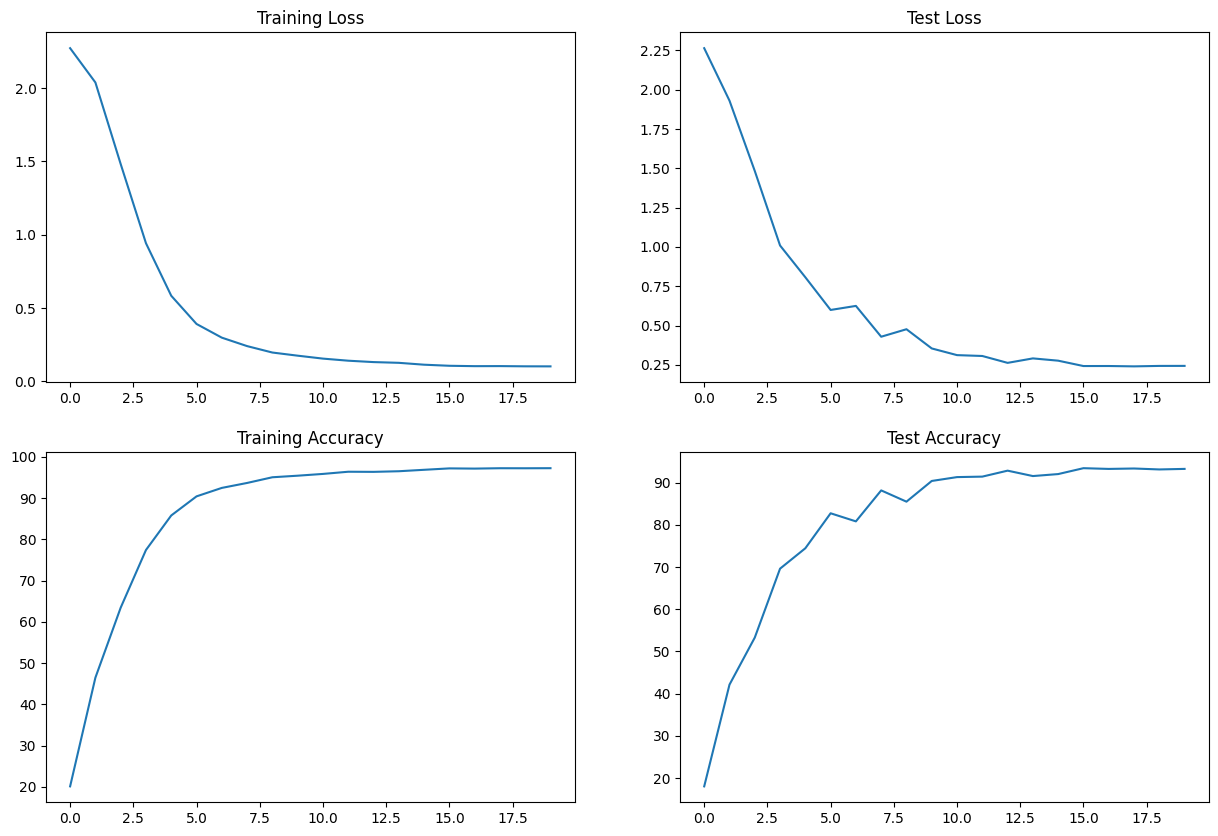

In [ ]:
plot_loss_accuracy(train_losses, train_acc, test_losses, test_acc)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,168
       BatchNorm2d-6           [-1, 16, 24, 24]              32
           Dropout-7           [-1, 16, 24, 24]               0
              ReLU-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10           [-1, 32, 10, 10]           4,640
      BatchNorm2d-11           [-1, 32, 10, 10]              64
          Dropout-12           [-1, 32, 10, 10]               0
    